<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделение-на-train/test" data-toc-modified-id="Разделение-на-train/test-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Разделение на train/test</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Подготовка

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor

In [2]:
RANDOM_STATE = 42

In [3]:
try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=0)
except:
    df = pd.read_csv('...', parse_dates=[0], index_col=0)

Задаю нулевой колонке тип datetime64, делаю ее индексом.

In [4]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


num_orders - количество заказов за прошедшие 10 минут.

In [5]:
df = df.sort_index()
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


На всякий случай сортирую данные по времени.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
df.isna().sum()

num_orders    0
dtype: int64

Данные с марта 2018 по август 2018. Пропущенных полей нет.

In [8]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Ресемплировала данные по одному часу.

## Анализ

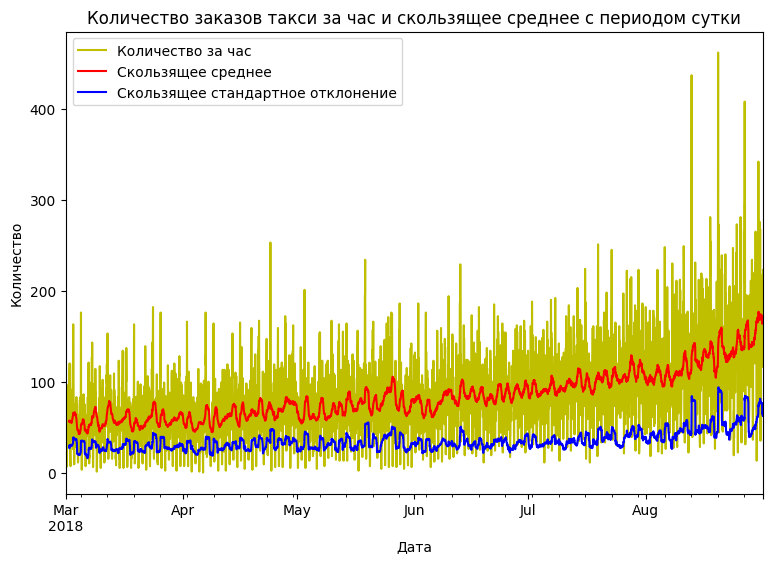

In [9]:
pd.concat([df, df.rolling(24).mean(), df.rolling(24).std()], axis=1)\
.plot(title='Количество заказов такси за час и скользящее среднее с периодом сутки', 
      figsize=(9, 6), 
      xlabel='Дата', color=['y', 'r', 'b'],
      ylabel='Количество')
plt.legend(['Количество за час', 'Скользящее среднее', 'Скользящее стандартное отклонение']);

По графику скользящего среднего видно, что в весенние месяцы распределение количества заказов такси особо не менялось, а летом количество заказов стало расти, особенно это заметно в августе.

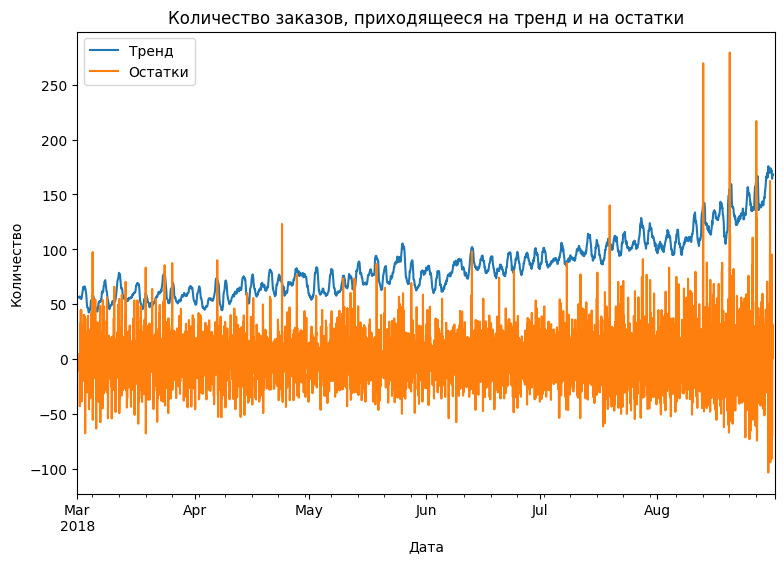

In [10]:
pd.DataFrame({'Тренд': seasonal_decompose(df).trend, 'Остатки': seasonal_decompose(df).resid})\
.plot(title='Количество заказов, приходящееся на тренд и на остатки', 
      figsize=(9, 6), 
      xlabel='Дата', 
      ylabel='Количество');

По графику видно, что летом есть тренд на рост. В августе разброс остатков увеличивается. Последовательность не является стационарной.

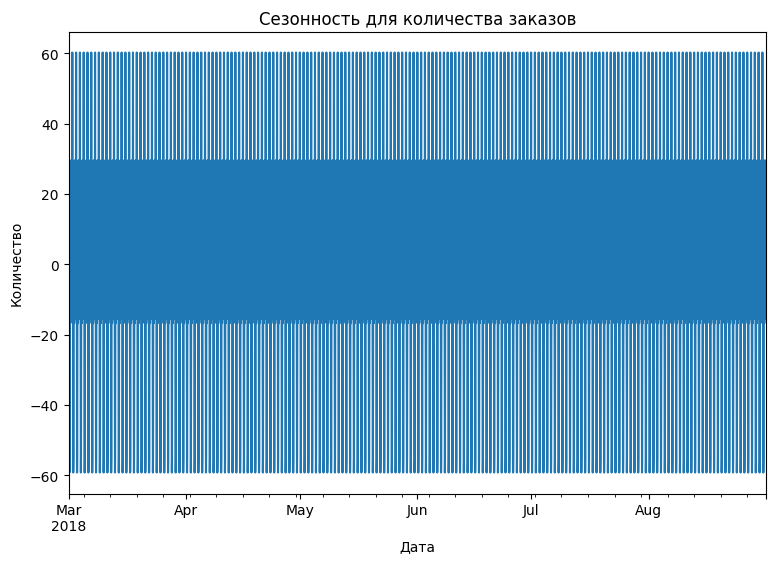

In [11]:
seasonal_decompose(df).seasonal.plot(title='Сезонность для количества заказов',
                                     figsize=(9, 6), 
                                     xlabel='Дата', 
                                     ylabel='Количество');

Сезонность присутствует, но по графику построенному по всему датасету сложно понять каков сезон.

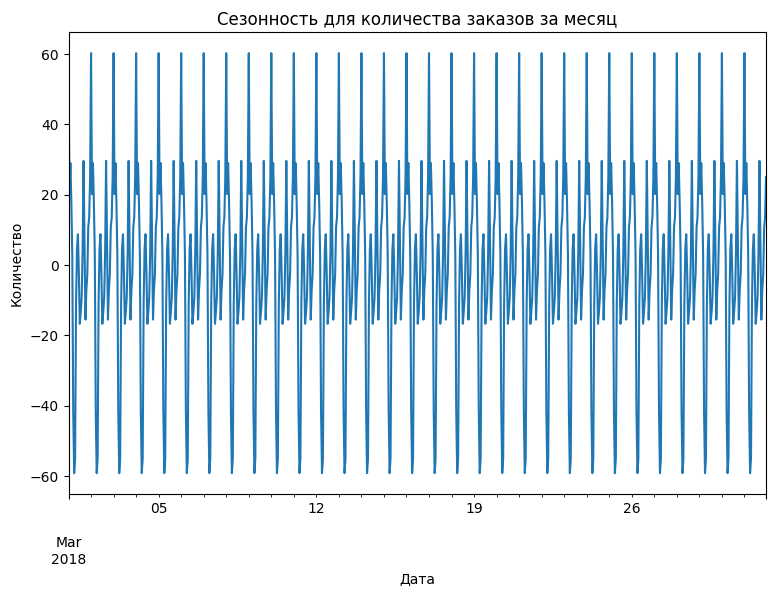

In [12]:
seasonal_decompose(df).seasonal['2018-03':'2018-03'].plot(title='Сезонность для количества заказов за месяц',
                                                          figsize=(9, 6), 
                                                          xlabel='Дата', 
                                                          ylabel='Количество');

По графику видно, что присутствует дневная сезонность

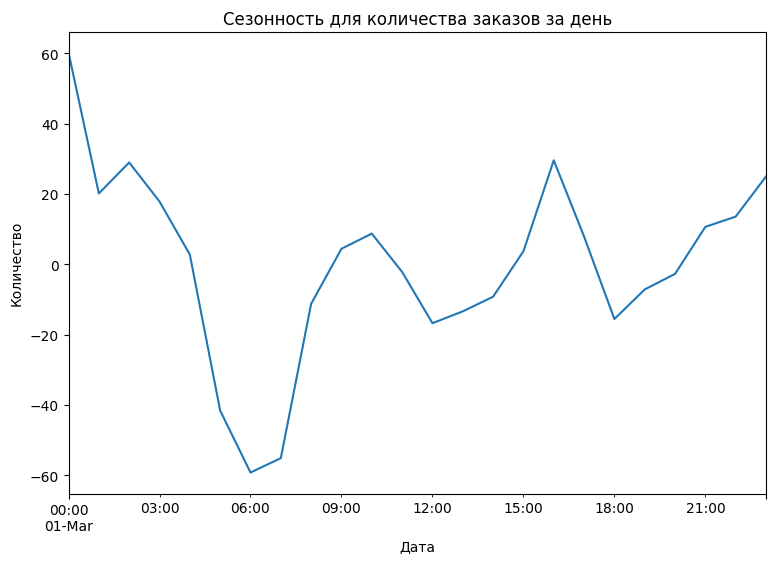

In [13]:
seasonal_decompose(df).seasonal['2018-03-01':'2018-03-01'].plot(title='Сезонность для количества заказов за день',
                                                                figsize=(9, 6), 
                                                                xlabel='Дата', 
                                                                ylabel='Количество');

Люди обычно часто заказывают такси утром 8-10, потом в обед около 15, потом после 19 и до позднего вечера. Редко - ночью и ранним утром, видимо спят.

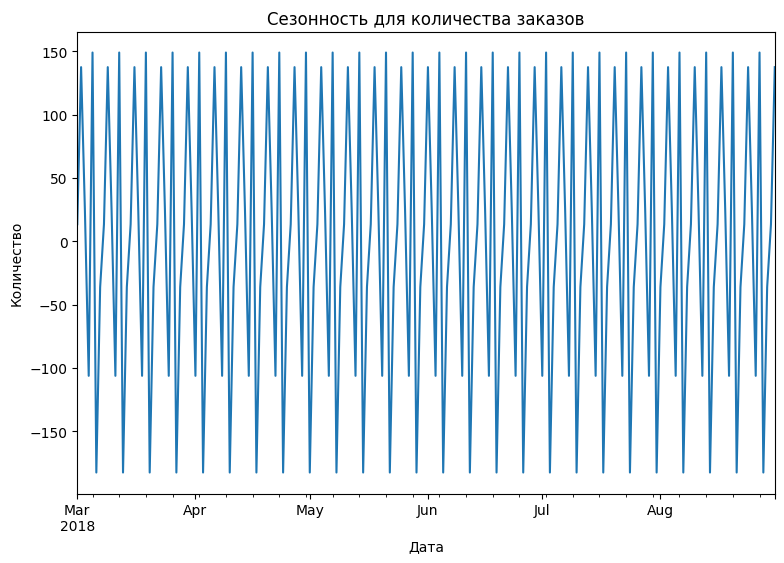

In [14]:
seasonal_decompose(df.resample('1D').sum()).seasonal.plot(title='Сезонность для количества заказов',
                                                          figsize=(9, 6), 
                                                          xlabel='Дата', 
                                                          ylabel='Количество');

Если ресемплировать данные по дням, то можно заметить и недельную сезонность.

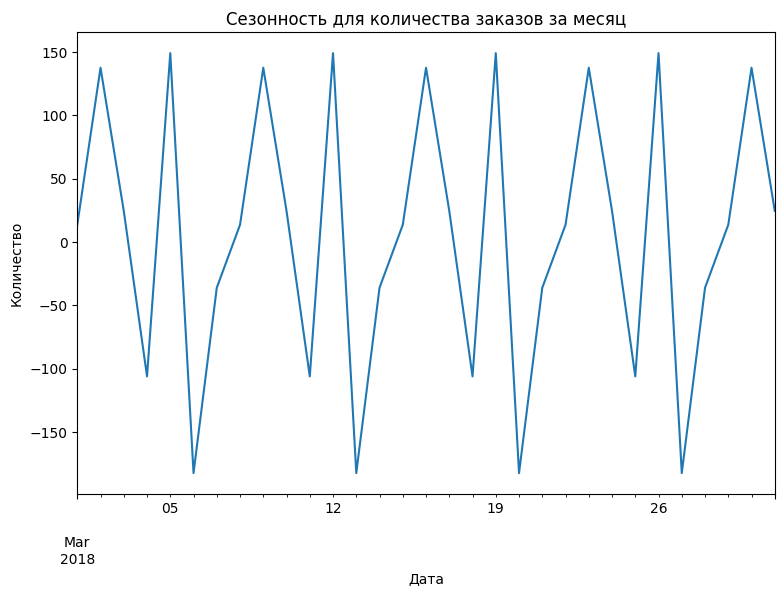

In [15]:
seasonal_decompose(df.resample('1D').sum()).seasonal['2018-03':'2018-03'].plot(title='Сезонность для количества заказов за месяц',
                                                                               figsize=(9, 6), 
                                                                               xlabel='Дата', 
                                                                               ylabel='Количество');

Cюдя по этому графику в понедельник и пятницу люди активно пользуются такси, а в воскресенье и вторник - мало.

## Создание признаков

In [16]:
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.day_of_week
df['hour'] = df.index.hour

In [17]:
cat_columns = ['month', 'day', 'day_of_week', 'hour']
cat_columns

['month', 'day', 'day_of_week', 'hour']

Создаю категориальные столбцы, для дальнейшей обработки сохраняю названия в список.

In [18]:
for i in range(1, 13):
    df[f'lag_{i}'] = df['num_orders'].shift(i)

Создаю 12 столбцов - лагов (значений, предшествующих текущему).

In [19]:
for i in [4, 12, 24]:
    df[f'rolling_mean_{i}'] = df['lag_1'].rolling(i).mean()

Создаю 3 столбца скользящих средних с размерами окон 4, 12, 24, строю по столбцу lag_1, чтобы  целевой признак не «убежал» в признаки.

In [20]:
num_columns = list(df.drop(columns=cat_columns + ['num_orders']).columns)
num_columns

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'rolling_mean_4',
 'rolling_mean_12',
 'rolling_mean_24']

Сохраняю имена числовых колонок в список.

In [21]:
df

,num_orders,month,day,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean_4,rolling_mean_12,rolling_mean_24
datetime,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.50,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,184.25,163.416667,164.875000
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,189.25,170.916667,167.541667
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,178.50,168.583333,168.041667


## Обучение

### Разделение на train/test

In [22]:
train, test = train_test_split(df, test_size=0.1, shuffle=False)

In [23]:
train = train.dropna()

In [24]:
print(f'Обучающая выбока находится в промежутке от {train.index.min()} до {train.index.max()}')
print(f'Тестовая выбока находится в промежутке от {test.index.min()} до {test.index.max()}')

Обучающая выбока находится в промежутке от 2018-03-02 00:00:00 до 2018-08-13 13:00:00
Тестовая выбока находится в промежутке от 2018-08-13 14:00:00 до 2018-08-31 23:00:00


In [25]:
X_train = train.drop(columns=['num_orders'])
X_test = test.drop(columns=['num_orders'])
y_train = train['num_orders']
y_test = test['num_orders']

Данные из обучающей выборки предшествуют данным из теста.

In [26]:
tscv = TimeSeriesSplit(n_splits=5)

Искать лучшие параметры моделей буду по решетке на кросс-валидации с помощью Time Series кросс-валидатора.

In [27]:
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

Создаю функцию, вычисляющую метрику RMSE.

### Линейная регрессия

In [28]:
column_transformer =\
ColumnTransformer([('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_columns), 
                   ('standart_scaler', StandardScaler(), num_columns)])

Для линейных моделей создаю трансформер для преобразования категорий с помощью OneHotEncoder, числовых колонок - с помощью StandartScaler.

In [29]:
pipeline_lr = Pipeline([('column_transformer', column_transformer),
                        ('lr', LinearRegression())])
param_grid_lr = {'lr__fit_intercept': (True, False), 
                 'lr__n_jobs':(-1,)}
grid_lr = GridSearchCV(estimator=pipeline_lr, 
                       param_grid=param_grid_lr,
                       cv=tscv,
                       scoring='neg_root_mean_squared_error',
                       n_jobs=-1)
grid_lr.fit(X_train, y_train)
grid_lr.best_score_

-116435955966667.6

In [30]:
pipeline_ridge = Pipeline([('column_transformer', column_transformer),
                           ('ridge', Ridge())])
param_grid_ridge = {'ridge__alpha': (0.001, 0.01, 0.1, 1, 10, 100, 1000),
                    'ridge__fit_intercept': (True, False), 
                    'ridge__solver': ('auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'), 
                    'ridge__random_state': (RANDOM_STATE,)}
grid_ridge = GridSearchCV(estimator=pipeline_ridge, 
                          param_grid=param_grid_ridge,
                          cv=tscv,
                          scoring='neg_root_mean_squared_error',
                          n_jobs=-1)
grid_ridge.fit(X_train, y_train)
grid_ridge.best_score_

-27.268757837692583

In [31]:
pipeline_lasso = Pipeline([('column_transformer', column_transformer),
                           ('lasso', Lasso(random_state=RANDOM_STATE))])
param_grid_lasso = {'lasso__alpha': (0.001, 0.01, 0.1, 1, 10, 100, 1000),
                    'lasso__fit_intercept': (True, False), 
                    'lasso__random_state': (RANDOM_STATE,)}
grid_lasso = GridSearchCV(estimator=pipeline_lasso, 
                          param_grid=param_grid_lasso,
                          cv=tscv,
                          scoring='neg_root_mean_squared_error',
                          n_jobs=-1)
grid_lasso.fit(X_train, y_train)
grid_lasso.best_score_

-25.90937319426657

Самая лучшая оценка на линейных моделях получена для модели Lasso.

In [32]:
best_param_lasso = {k[7:]:v for k,v in grid_lasso.best_params_.items()}

In [33]:
print(f'Лучшие параметры: {best_param_lasso}, Среднее RMSE на кросс-валидации: {round(-grid_lasso.best_score_, 2)}')

Лучшие параметры: {'alpha': 0.1, 'fit_intercept': True, 'random_state': 42}, Среднее RMSE на кросс-валидации: 25.91


### Дерево решений

In [34]:
param_grid_dt = {'criterion': ('mse', 'mae', 'friedman_mse','poisson'),
                 'max_depth': range(2, 101),
                 'min_samples_split': (5, 10, 20, 50, 100),
                 'random_state': (RANDOM_STATE,)}
grid_dt = GridSearchCV(estimator=DecisionTreeRegressor(), 
                       param_grid=param_grid_dt,
                       cv=tscv,
                       scoring='neg_root_mean_squared_error',
                       n_jobs=-1) 
grid_dt.fit(X_train, y_train)
grid_dt.best_score_

-28.770111045573003

In [35]:
print(f'Лучшие параметры для дерева решений: {grid_dt.best_params_}, Среднее RMSE на кросс-валидации: {round(-grid_dt.best_score_, 2)}')

Лучшие параметры для дерева решений: {'criterion': 'mse', 'max_depth': 8, 'min_samples_split': 50, 'random_state': 42}, Среднее RMSE на кросс-валидации: 28.77


### CatBoost

In [36]:
param_grid_cb = {'depth': range(2, 11, 2),
                 'iterations': range(20, 201, 20), 
                 'learning_rate' : (0.01, 0.05, 0.1),
                 'cat_features': (cat_columns,),
                 'random_seed': (RANDOM_STATE,)}
grid_cb = RandomizedSearchCV(estimator=CatBoostRegressor(), 
                             param_distributions=param_grid_cb,
                             n_iter=50,
                             cv=tscv,
                             scoring='neg_root_mean_squared_error',
                             n_jobs=-1, 
                             random_state=RANDOM_STATE) 
grid_cb.fit(X_train, y_train)
grid_cb.best_score_

0:	learn: 38.0644899	total: 157ms	remaining: 28.1s
1:	learn: 37.4723723	total: 183ms	remaining: 16.3s
2:	learn: 36.9324971	total: 215ms	remaining: 12.7s
3:	learn: 36.4208377	total: 229ms	remaining: 10.1s
4:	learn: 35.9108194	total: 244ms	remaining: 8.53s
5:	learn: 35.4939968	total: 257ms	remaining: 7.46s
6:	learn: 35.1011137	total: 275ms	remaining: 6.79s
7:	learn: 34.6881427	total: 292ms	remaining: 6.27s
8:	learn: 34.0103542	total: 324ms	remaining: 6.16s
9:	learn: 33.3810352	total: 355ms	remaining: 6.04s
10:	learn: 32.7316997	total: 386ms	remaining: 5.93s
11:	learn: 32.1268662	total: 402ms	remaining: 5.63s
12:	learn: 31.5632077	total: 432ms	remaining: 5.54s
13:	learn: 31.0675757	total: 448ms	remaining: 5.31s
14:	learn: 30.5582942	total: 478ms	remaining: 5.26s
15:	learn: 30.1118942	total: 490ms	remaining: 5.02s
16:	learn: 29.6787617	total: 508ms	remaining: 4.87s
17:	learn: 29.2907048	total: 519ms	remaining: 4.67s
18:	learn: 28.9344035	total: 539ms	remaining: 4.57s
19:	learn: 28.5697269	

160:	learn: 21.7932066	total: 3.19s	remaining: 376ms
161:	learn: 21.7737782	total: 3.22s	remaining: 357ms
162:	learn: 21.7654823	total: 3.23s	remaining: 337ms
163:	learn: 21.7578307	total: 3.25s	remaining: 317ms
164:	learn: 21.7524496	total: 3.26s	remaining: 296ms
165:	learn: 21.7488974	total: 3.28s	remaining: 276ms
166:	learn: 21.7431660	total: 3.29s	remaining: 256ms
167:	learn: 21.7177837	total: 3.34s	remaining: 238ms
168:	learn: 21.7145939	total: 3.35s	remaining: 218ms
169:	learn: 21.7117518	total: 3.37s	remaining: 198ms
170:	learn: 21.6954878	total: 3.38s	remaining: 178ms
171:	learn: 21.6890593	total: 3.43s	remaining: 160ms
172:	learn: 21.6838872	total: 3.5s	remaining: 141ms
173:	learn: 21.6532011	total: 3.54s	remaining: 122ms
174:	learn: 21.6468279	total: 3.55s	remaining: 102ms
175:	learn: 21.6386265	total: 3.57s	remaining: 81.2ms
176:	learn: 21.6306612	total: 3.62s	remaining: 61.3ms
177:	learn: 21.6028912	total: 3.63s	remaining: 40.8ms
178:	learn: 21.5925968	total: 3.66s	remainin

-25.42856327103682

In [37]:
grid_cb.best_params_

{'random_seed': 42,
 'learning_rate': 0.05,
 'iterations': 180,
 'depth': 6,
 'cat_features': ['month', 'day', 'day_of_week', 'hour']}

Поищую лучшие параметры около тех, что были получены на предыдущем шаге.

In [38]:
param_grid_cb = {'depth': (5, 6, 7),
                 'iterations': range(160, 201, 5), 
                 'learning_rate' : (0.05,),
                 'cat_features': (cat_columns,),
                 'random_seed': (RANDOM_STATE,)}
grid_cb = GridSearchCV(estimator=CatBoostRegressor(), 
                       param_grid=param_grid_cb,
                       cv=tscv,
                       scoring='neg_root_mean_squared_error',
                       n_jobs=-1) 
grid_cb.fit(X_train, y_train)
grid_cb.best_score_

0:	learn: 38.0644899	total: 30.9ms	remaining: 6s
1:	learn: 37.4723723	total: 44.7ms	remaining: 4.32s
2:	learn: 36.9324971	total: 59.8ms	remaining: 3.83s
3:	learn: 36.4208377	total: 89.6ms	remaining: 4.28s
4:	learn: 35.9108194	total: 105ms	remaining: 3.97s
5:	learn: 35.4939968	total: 121ms	remaining: 3.81s
6:	learn: 35.1011137	total: 151ms	remaining: 4.06s
7:	learn: 34.6881427	total: 182ms	remaining: 4.26s
8:	learn: 34.0103542	total: 196ms	remaining: 4.05s
9:	learn: 33.3810352	total: 228ms	remaining: 4.21s
10:	learn: 32.7316997	total: 243ms	remaining: 4.07s
11:	learn: 32.1268662	total: 257ms	remaining: 3.92s
12:	learn: 31.5632077	total: 274ms	remaining: 3.83s
13:	learn: 31.0675757	total: 291ms	remaining: 3.76s
14:	learn: 30.5582942	total: 307ms	remaining: 3.69s
15:	learn: 30.1118942	total: 326ms	remaining: 3.64s
16:	learn: 29.6787617	total: 355ms	remaining: 3.72s
17:	learn: 29.2907048	total: 374ms	remaining: 3.67s
18:	learn: 28.9344035	total: 388ms	remaining: 3.59s
19:	learn: 28.5697269

165:	learn: 21.7488974	total: 3.29s	remaining: 575ms
166:	learn: 21.7431660	total: 3.32s	remaining: 557ms
167:	learn: 21.7177837	total: 3.33s	remaining: 536ms
168:	learn: 21.7145939	total: 3.35s	remaining: 516ms
169:	learn: 21.7117518	total: 3.37s	remaining: 495ms
170:	learn: 21.6954878	total: 3.38s	remaining: 475ms
171:	learn: 21.6890593	total: 3.4s	remaining: 454ms
172:	learn: 21.6838872	total: 3.41s	remaining: 434ms
173:	learn: 21.6532011	total: 3.44s	remaining: 416ms
174:	learn: 21.6468279	total: 3.47s	remaining: 397ms
175:	learn: 21.6386265	total: 3.49s	remaining: 377ms
176:	learn: 21.6306612	total: 3.52s	remaining: 358ms
177:	learn: 21.6028912	total: 3.54s	remaining: 338ms
178:	learn: 21.5925968	total: 3.55s	remaining: 318ms
179:	learn: 21.5907647	total: 3.56s	remaining: 297ms
180:	learn: 21.5860566	total: 3.58s	remaining: 277ms
181:	learn: 21.5833636	total: 3.59s	remaining: 257ms
182:	learn: 21.5607843	total: 3.63s	remaining: 238ms
183:	learn: 21.5458411	total: 3.64s	remaining: 

-25.382729297383868

In [39]:
grid_cb.best_params_

{'cat_features': ['month', 'day', 'day_of_week', 'hour'],
 'depth': 6,
 'iterations': 195,
 'learning_rate': 0.05,
 'random_seed': 42}

In [40]:
print(f'Лучшие параметры для бустинга: {grid_cb.best_params_}, Среднее RMSE на кросс-валидации: {round(-grid_cb.best_score_, 2)}')

Лучшие параметры для бустинга: {'cat_features': ['month', 'day', 'day_of_week', 'hour'], 'depth': 6, 'iterations': 195, 'learning_rate': 0.05, 'random_seed': 42}, Среднее RMSE на кросс-валидации: 25.38


## Тестирование

Лучшие результаты получены на кросс-валидации для CatBoost-регрессора.

In [41]:
best_model = CatBoostRegressor(**grid_cb.best_params_)
best_model.fit(X_train, y_train)

0:	learn: 38.0644899	total: 35.1ms	remaining: 6.82s
1:	learn: 37.4723723	total: 48.2ms	remaining: 4.65s
2:	learn: 36.9324971	total: 60.7ms	remaining: 3.88s
3:	learn: 36.4208377	total: 78.6ms	remaining: 3.75s
4:	learn: 35.9108194	total: 104ms	remaining: 3.95s
5:	learn: 35.4939968	total: 126ms	remaining: 3.95s
6:	learn: 35.1011137	total: 141ms	remaining: 3.79s
7:	learn: 34.6881427	total: 156ms	remaining: 3.64s
8:	learn: 34.0103542	total: 173ms	remaining: 3.57s
9:	learn: 33.3810352	total: 187ms	remaining: 3.45s
10:	learn: 32.7316997	total: 199ms	remaining: 3.34s
11:	learn: 32.1268662	total: 215ms	remaining: 3.28s
12:	learn: 31.5632077	total: 230ms	remaining: 3.22s
13:	learn: 31.0675757	total: 255ms	remaining: 3.29s
14:	learn: 30.5582942	total: 281ms	remaining: 3.38s
15:	learn: 30.1118942	total: 312ms	remaining: 3.49s
16:	learn: 29.6787617	total: 327ms	remaining: 3.42s
17:	learn: 29.2907048	total: 342ms	remaining: 3.36s
18:	learn: 28.9344035	total: 357ms	remaining: 3.3s
19:	learn: 28.56972

158:	learn: 21.8412218	total: 3.03s	remaining: 686ms
159:	learn: 21.8250251	total: 3.05s	remaining: 667ms
160:	learn: 21.7932066	total: 3.06s	remaining: 647ms
161:	learn: 21.7737782	total: 3.08s	remaining: 627ms
162:	learn: 21.7654823	total: 3.09s	remaining: 608ms
163:	learn: 21.7578307	total: 3.11s	remaining: 588ms
164:	learn: 21.7524496	total: 3.12s	remaining: 568ms
165:	learn: 21.7488974	total: 3.14s	remaining: 549ms
166:	learn: 21.7431660	total: 3.15s	remaining: 528ms
167:	learn: 21.7177837	total: 3.17s	remaining: 510ms
168:	learn: 21.7145939	total: 3.19s	remaining: 490ms
169:	learn: 21.7117518	total: 3.2s	remaining: 470ms
170:	learn: 21.6954878	total: 3.22s	remaining: 452ms
171:	learn: 21.6890593	total: 3.25s	remaining: 435ms
172:	learn: 21.6838872	total: 3.26s	remaining: 415ms
173:	learn: 21.6532011	total: 3.28s	remaining: 396ms
174:	learn: 21.6468279	total: 3.31s	remaining: 379ms
175:	learn: 21.6386265	total: 3.34s	remaining: 361ms
176:	learn: 21.6306612	total: 3.36s	remaining: 

In [42]:
print('RMSE "наивного" регрессора на тесте', round(RMSE(y_test, DummyRegressor().fit(X_train, y_train).predict(X_test)), 2))
print('RMSE лучшей модели на трейне', round(RMSE(y_train, best_model.predict(X_train)), 2))
print('RMSE лучшей модели на тесте', round(RMSE(y_test, best_model.predict(X_test)), 2))

RMSE "наивного" регрессора на тесте 84.65
RMSE лучшей модели на трейне 20.88
RMSE лучшей модели на тесте 43.34


Лучшие результаты на кросс-валидации показала модель CatBoost, ее RMSE около 43, что гораздо лучше этой метрики у "наивного" регрессора (~85)

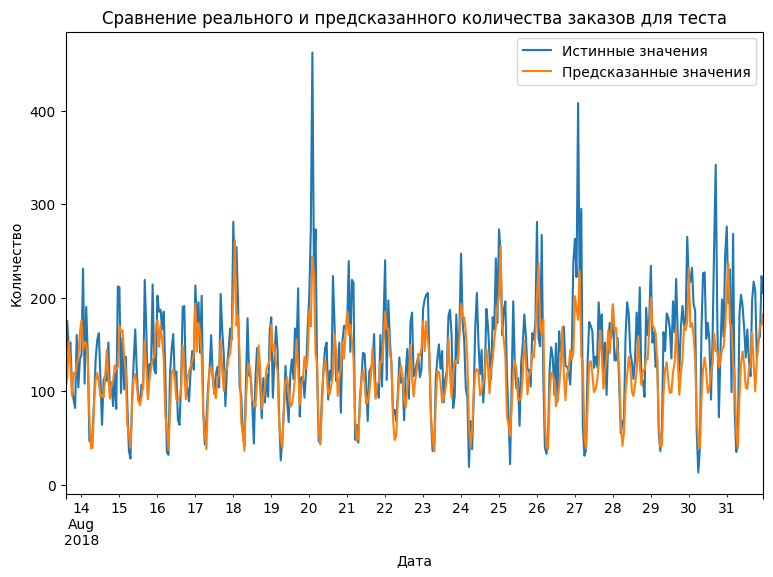

In [43]:
pd.DataFrame({'true': y_test, 'pred': best_model.predict(X_test)})\
.plot(title='Сравнение реального и предсказанного количества заказов для теста', 
      figsize=(9, 6), 
      xlabel='Дата',
      ylabel='Количество')
plt.legend(['Истинные значения', 'Предсказанные значения']);

Графики реального количества заказов и спрогнозированного моделью очень похожи. В реальных данных есть два выброса 20 августа и 27 августа (нетипично большое количество заказов), в эти дни модель не смогла сработать точно.

## Вывод

Были предложены исторические данные о заказах такси в аэропортах в промежутоке от 01.03.2018 до 31.08.2018. Запись в данных представляет собой количество появившихся заказов такси за каждые 10 минут времени. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Была проведена сортировка данных по времени и ресемплирование данных по одному часу (так предсказание нужно сделать на следующий час, а не на 10 минут).

Были проанализировнны графики количества заказов, скользящего стандартного среднего с окном 24 часа, скользящего стандартного отклонения. В весенние месяцы распределение количества заказов такси особо не менялось, а летом количество заказов стало расти, особенно это заметно в августе.

Были проанализированы графики количеств заказов, приходящееся на тренд и на остатки. Так как летом есть тренд на рост, а в августе разброс остатков увеличивается, сделан вывод, что последовательность данных не является стационарной.

С помощью графического метода обнаруженна дневная и недельная сезонности в данных. Люди обычно часто заказывают такси утром 8-10, потом в обед около 15, потом после 19 и до позднего вечера. Редко - ночью и ранним утром. В понедельник и пятницу люди активно пользуются такси, а в воскресенье и вторник - мало.

Для дальнейшего обучения моделей машинного обучения были сформированны категориальные признаки (час, день, день недели, месяц) и числовые признаки 12 столбцов лагов (от 1 до 12 часов) и три столбца скользящих средних для предыдушего значения с окнами 4, 12, 24 часов.

Данные были поделены на обучающую и тестовую выбоку в соотношении 90 на 10, при этом порядок следования был не нарушен, чтобы тестовая выборка была с более поздними датами, чем обучающая. Из обучающих данных удалены пропущенные значения появившиеся в процессе формирования столбцов.

С помощью обучения по решетке на кросс-валидции (TimeSeriesSplit) были обучены различные модели (Линейные, Дерева решений, CatBoost). Перед применением линейных моделей категории и числовые столбцы были трансформированы OneHotEncoder и StandartScaler соответственно. Для дерева решений и Catboost энкодеры к данным не применялись. Лучшие результаты на кросс-валидации показала модель CatBoost,  ее RMSE около 43, что гораздо лучше этой метрики у "наивного" регрессора (~85).

Были построены графики реального количества заказов и предсказанного моделью для тестовой выборки. Графики очень схожи, но из-за двух выбросов, которые модель не смогла точно предсказать, метрика RMSE не показала более выдающийся результат.